### 这节课我们简单介绍

- 目标检测
    - 滑窗法
    - R-CNN (Region Proposal)
    - Fast R-CNN
    - Faster R-CNN
- Mask R-CNN

**为什么介绍目标检测这些模型？**  
Mask R-CNN与R-CNN、Fast R-CNN、Faster R-CNN之间联系紧密，包括网络结构、训练方式，Mask R-CNN的网络设计取自Faster R-CNN

**Mask R-CNN与其他大部分图像分割模型区别很大**
- Mask R-CNN是二阶段训练模型（Two Stage），UNet等分割模型是一阶段训练模型（Single Stage）
- Mask R-CNN不仅输出图像分割（Mask），同时输出检测框（Bounding Box），UNet等分割模型输出分割（Mask）

**这个讲义不涉及代码、公式，在不影响理解前提下简化了细节，目的是对这些网络整体设计有一个大概了解。强烈建议阅读论文及代码深入理解原理。**

In [1]:
from PIL import Image

### 移动滑窗——穷举法

- 从左向右，自上而下滑动
- 多种大小，多种长宽比的滑窗
- 每一个滑窗切割出一小块图片，送入卷积网络

缺点明显：生成大量overlap的小块图片，运算冗余巨大效率低

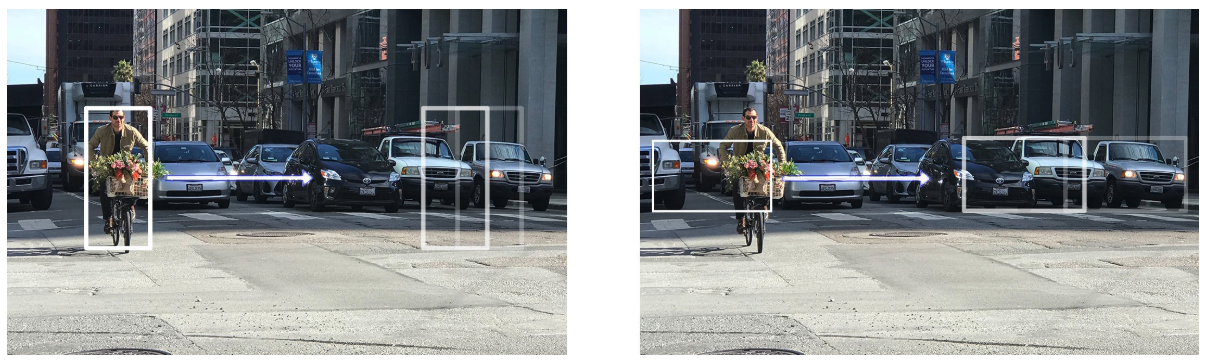

In [2]:
Image.open('assets/sliding window.png')

基于滑窗法的卷积神经网络做目标检测

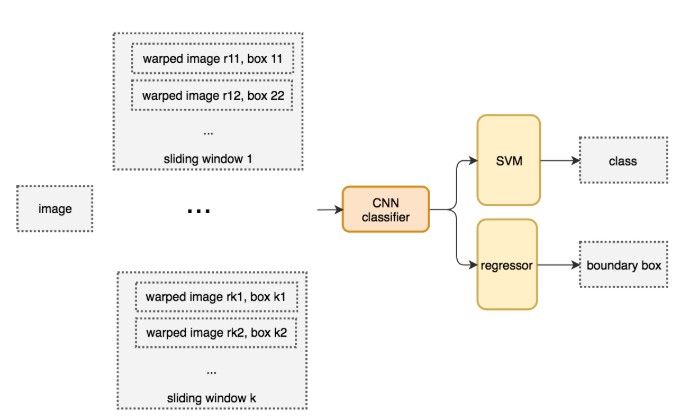

In [3]:
Image.open('assets/sliding window network.png')

### R-CNN (Region Proposal)

在滑窗的思路上，为了减少冗余计算量，提出Region Proposal思想，具体的指“Selective Search”算法，即使用传统图像的方法从图像上计算出2000张**regions of interest (ROIs)，**输入CNN分类器网络。

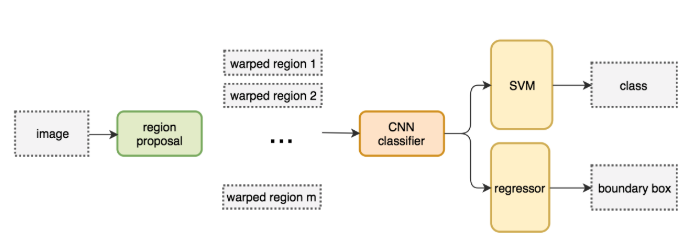

In [4]:
Image.open('assets/System flow for R-CNN.png')

“Selective Search”算法原理：

由一个像素点开始，根据以下规则合并相邻两个区域
- 颜色（颜色直方图）相近的
- 纹理（梯度直方图）相近的
- 合并后总面积小的，从面积小的优先开始合并，避免一个大面积的区域吃掉所有周围小的区域  

最终输出所有过程中存在过的区域，称为候选区域regions of interest

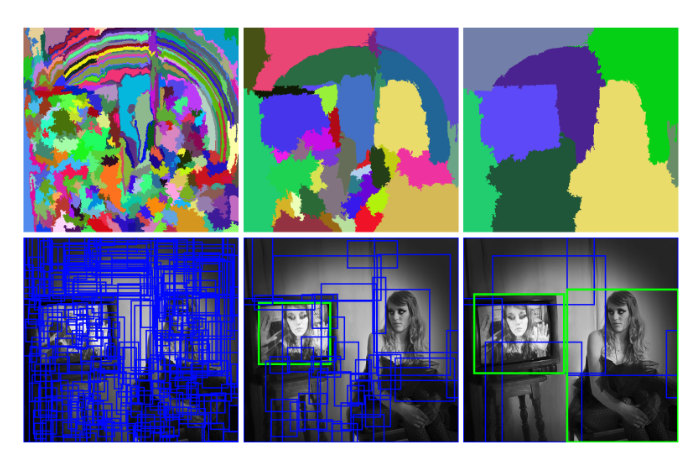

In [5]:
Image.open('assets/region proposal.png')

思考：可以认为“Selective Search”算法做了一个图像预处理，将可能包含一个object的候选区域切割出来构成一个候选集吗？

相比滑窗方法，R-CNN使用Region Proposal方法，虽然候选区域大量减少，但候选区域的质量更高，从而使得网络检测精度更高。下面是R-CNN网络架构图。

缺点：R-CNN需要大量overlap的候选区域才能取得不错效果，使得训练和推理速度非常慢（虽然比滑窗快）。假如2000个候选区域，每一个候选区域是一个图片输入CNN中提取图片特征，我们要重复这个操作2000次。

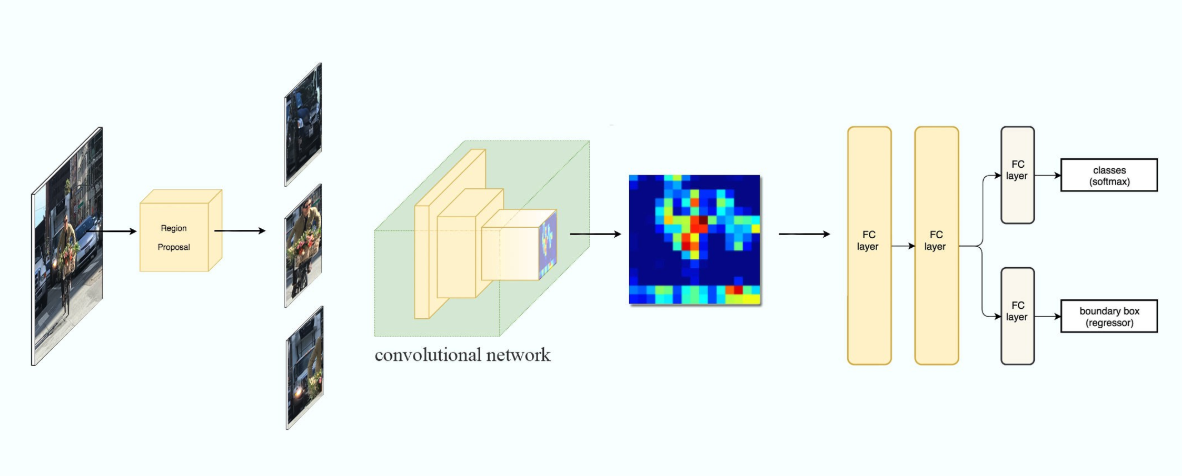

In [6]:
Image.open('assets/R-CNN architecture.png')

### Fast R-CNN

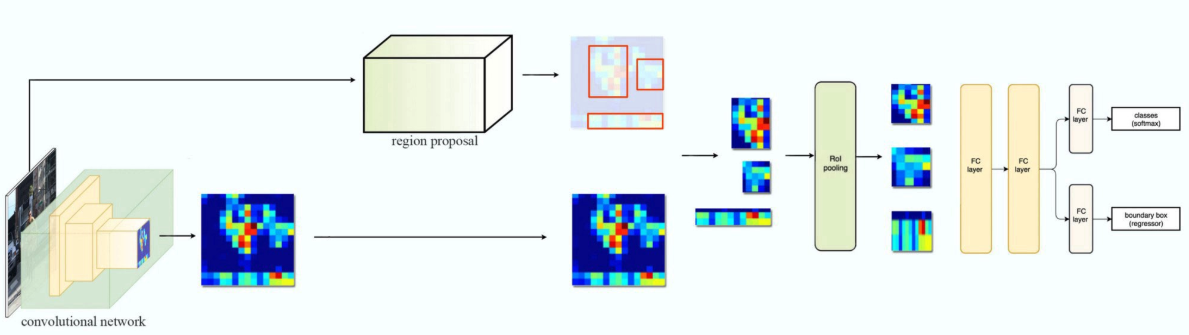

In [7]:
Image.open('assets/Fast R-CNN architecture.png')

Fast R-CNN比R-CNN计算更快。操作流程：
- 先用一个CNN网络对整张图片提取特征
- 同样使用Region Proposal方法产生2000张候选区域ROI
- 将特征图与候选区域一起传入ROI Pooling层，调整成固定尺寸
- 输入FCNN，输出候选区域的分类和BBox定位

快在哪？快在CNN对整张图片做一次特征提取，而不是2000次。Fast R-CNN训练比R-CNN快10倍，推理阶段快150倍。

ROI Pooling层做了什么？
- 将候选区域对应到整张图提取出来的特征图上，获取到的是特征图上相应坐标位置的区域
- 由于传入的特征图区域尺寸不同，需要预先设定一个固定尺寸的特征图大小，并且手动计算每一张传入的特征图区域Pooling的尺度
- 最后将所有特征图区域相同尺寸合并，传入后续FCNN

一个例子：假如特征图$8\times8$，现在需要Pooling成$2\times2$
- 图1:输入特征图
- 图2:蓝色框是我们的候选区域，覆盖到特征图上
- 图3:我们将候选区域内（近似）平均分割成目标尺寸$2\times2$的子区域
- 图4:每个子区域内计算最大值，输出$2\times2$的特征图

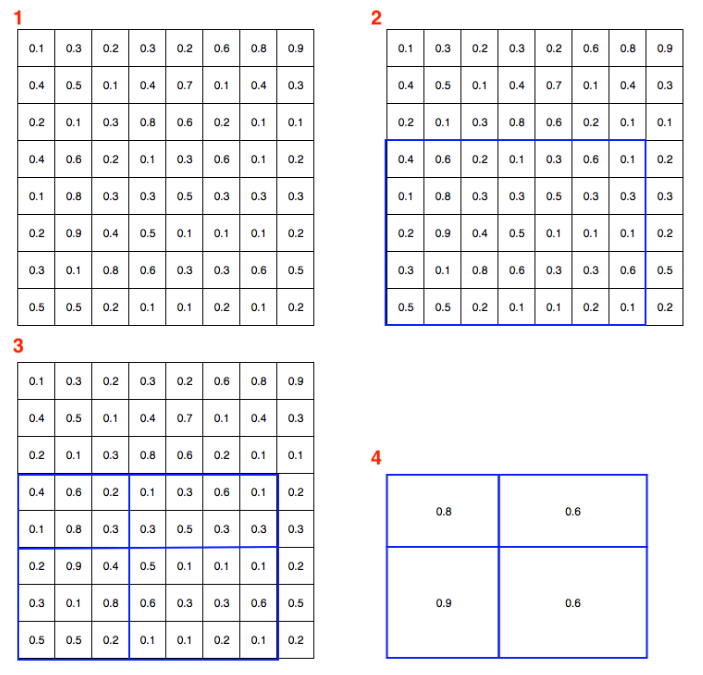

In [9]:
Image.open('assets/ROI Pooling.png')

### Faster R-CNN

R-CNN和Fast R-CNN使用Region Proposal方法（“Selective Search”算法）是基于CPU计算的方法。比如推理阶段，预测一个样本需要2秒钟提取2000个候选区域。

Faster R-CNN提出Region Proposal Network（卷积网络）替代原先的Region Proposal方法，可以在GPU上提取ROI。预测一个样本需要大约0.2秒。

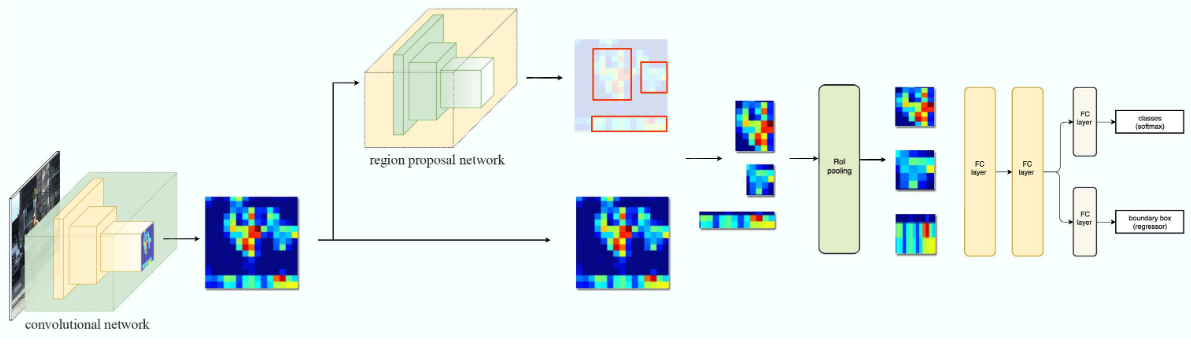

In [10]:
Image.open('assets/Faster R-CNN architecture.png')

**Region Proposal Network**

使用卷积核作用在特征图上，并在每一个像素点生成$k$个候选框（不同尺寸、长宽比），假如输入特征图$8\times8$，那么总共生成$8\times8\times3=192$个候选框，同时每一个候选框输出1.目标分类2.左上右下2个顶点坐标。

这$k$个候选框的设定很重要，下一步我们根据候选框，对其顶点坐标进行矫正。这些候选框的设定满足：
- 多种尺寸大小
- 多种长宽比

从而能够尽量涵盖自然场景物体的各种可能外形。例如尺寸128², 256², 512²，以及长宽比 1:1，1:2，2:1

**这些候选框在论文中称为"anchor"**

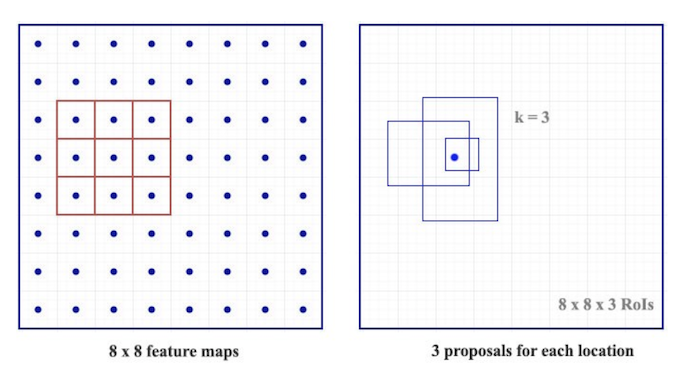

In [16]:
Image.open('assets/region proposal network0.png')

我们知道Faster R-CNN是二阶段训练模型

第一阶段训练RPN，对于每一个生成的候选框，满足以下任意条件为正样本（包含一个目标）：
- 候选框与任意一个GT目标框之间IOU>0.7，一个GT目标框可能产生多个正样本候选框（这对后续网络训练矫正候选框顶点坐标带来更高精度）
- 候选框是某一个GT目标框所有相交候选框中IOU最高的一个（可能全部低于0.7，为什么？比如目标物体比较大）

负样本远远大于正样本。因此抽取128个正样本与128个负样本作为一个batch训练。Loss函数是一个多任务损失函数，包含两部分，一是分类，二是顶点坐标的回归。

第二阶段训练整个网络。其中RPN使用第一阶段的权重初始化，生成候选框区域。第一阶段预训练的RPN权重能够生成更好的候选框集合。

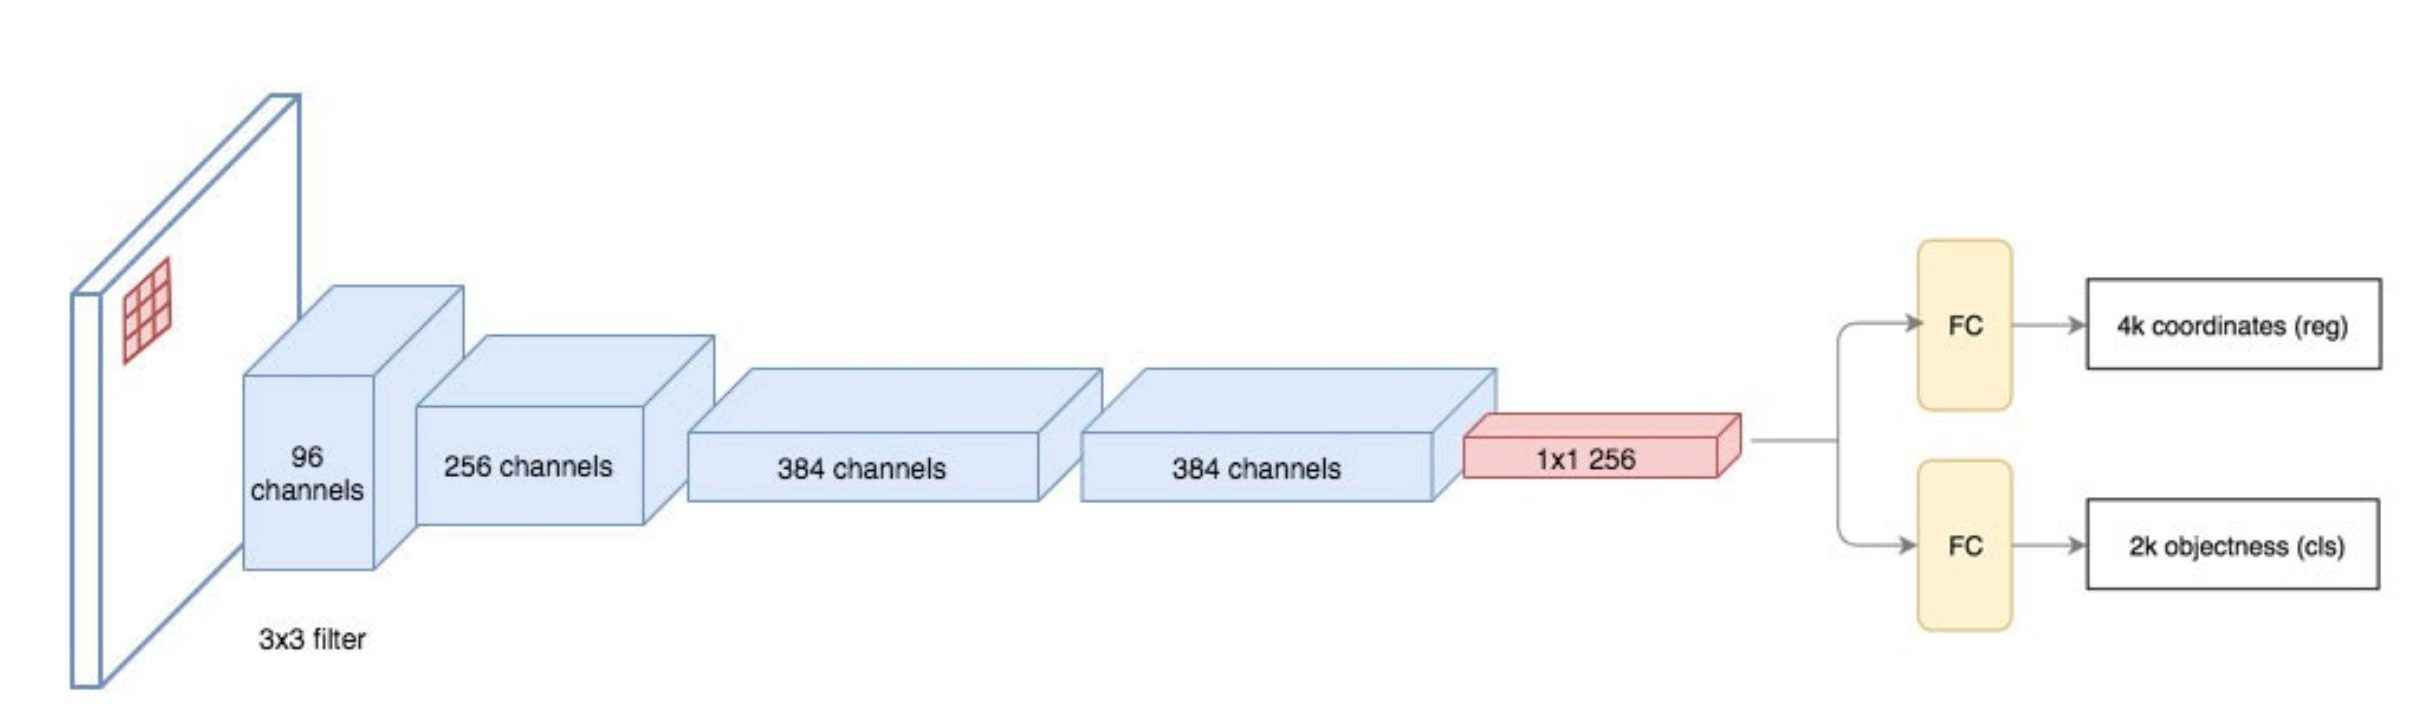

In [17]:
Image.open('assets/region proposal network1.png')

### Mask R-CNN

至此，整合我们介绍的Faster R-CNN和相关概念，我们知道RPN做了
- 使用卷积网络从特征图上抽取候选框区域
- 使用ROI Pooling将候选框区域与底层特征图结合，输出统一尺寸特征图
- 分别进入两个不共享权重的头网络（Head），一个训练分类目标框，另一个训练顶点坐标值回归

以上是目标检测任务。**Mask R-CNN不改变网络整体架构，在最后新添加第三个头网络（Head），用来预测Mask。**

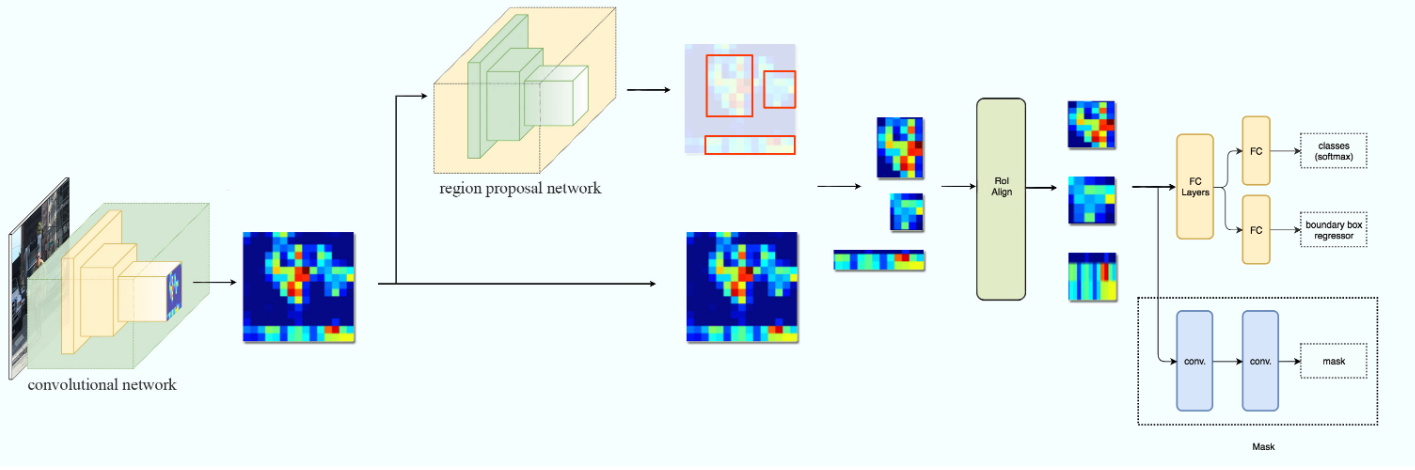

In [18]:
Image.open('assets/Mask R-CNN architecture.png')

**下面我们通过可视化了解Mask R-CNN**

RPN训练后，输出的候选框集合，只选取了一部分可视化。此时RPN已能够产生一些相当高质量的候选框了。

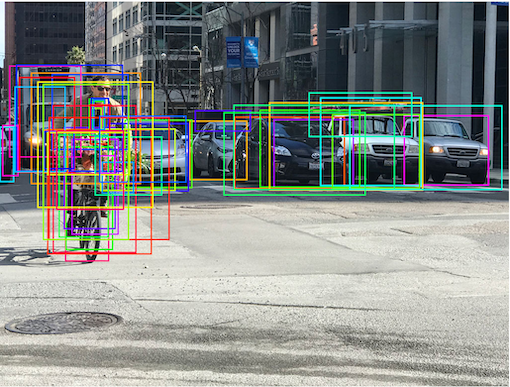

In [36]:
Image.open('assets/mask rcnn fig0.png')

第二阶段利用RPN权重初始化训练整个网络，最终输出目标框、分类、以及遮罩层。

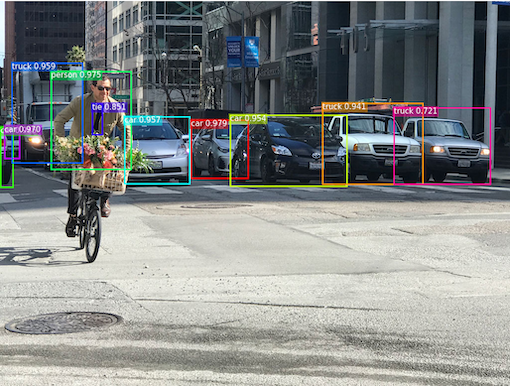

In [42]:
Image.open('assets/mask rcnn fig3.png')

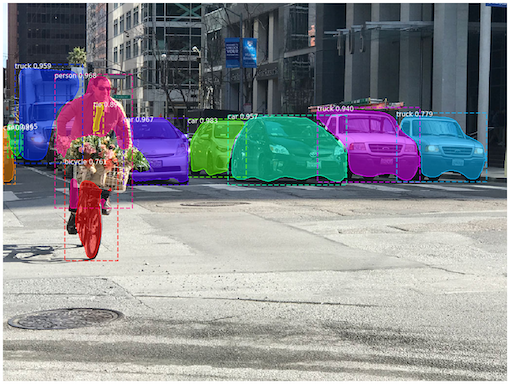

In [43]:
Image.open('assets/mask rcnn fig4.png')

### [参考Facebook开源的R-CNN系列实现代码](https://github.com/facebookresearch/detectron2)